# Segmentando Glóbulos rojos para detectar  la Malaria

## Introducción

![](muestra.jpg)


Uno de los cuadros hematológicos que pueden tener un gran impacto en la salud del paciente es el de las anemias, y especialmente los cuadros agudos de anemias hemolíticas en los que se sobrepasa la capacidad de compensación de la médula ósea para producir nuevos glóbulos rojos (hematíes). Existen cuatro casos que pueden poner en riesgo la situación clínica del paciente, por lo que es esencial tomar las medidas terapéuticas oportunas a tiempo: la malaria, las anemias microangiopáticas, la anemia hemolítica autoinmune y la drepanocitosis. 

Los cambios morfológicos producidos en los hematíes por estos cuadros pueden confirmarse con el análisis visual del frotis de sangre periférica (SP) en un microscopio óptico. Como la SP es un fluido fácilmente accesible, este análisis es clave para una primera detección de anomalías en las células circulantes. La OMS considera la morfología celular, junto a otras técnicas como el inmunofenotipo y la genética, esencial para el diagnóstico de las enfermedades hematológicas, siendo imprescindible para las anemias y trombocitopenias, así como para la identificación y caracterización de diferentes hemopatías malignas. 

El principal inconveniente del frotis de SP es el consumo de tiempo que conlleva una revisión adecuada y la disponibilidad de un personal con amplia experiencia en su interpretación objetiva y fiable. Por ello, algunos investigadores han desarrollado sistemas computarizados que combinan el procesamiento digital de imágenes de microscopio con algoritmos de reconocimiento de patrones, para la identificación de diferentes elementos sanguíneos. Estos podrían ser útiles para el diagnóstico morfológico, añadiendo precisión y fiabilidad, y completando la interpretación manual con medidas objetivas. A pesar de los esfuerzos para desarrollar un sistema de reconocimiento automático de las alteraciones morfológicas de los hematíes, no existe todavía un método de diagnóstico fiable y preciso para las anemias hemolíticas graves. 

Por esta razón,  en este proyecto realizaremos diversas técnicas para segmentar y detectar hematíes (ó glóblulos rojos - RBC) para ayudar a identificar en un futuro posibles patologías de las cuatro entidades clínicas de mayor riesgo causantes de anemias hemolíticas graves: a) la malaria asociada al Plasmodium Falciparum, la más importante de las especies de malaria por su malignidad; b) la anemia hemolítica autoinmune asociada a la presencia de esferocitos en la SP; c) la anemia falciforme asociada a drepanocitos; y d) la micoangiopatía trombótica (púrpura trombótica trombocitopénica, síndrome hemolítico-urémico o secundaria) asociada a esquistocitos.

Herramienta para construir las etiquetas de referencia: https://cvat.org/

LA idea es construir un ground truth usando cvat y posteriormente idear algunos algoritmos de segmentación. 1. Técnica básica con otsu, 2. color clustering básico con kmeans y luego gmm, 3. super pixels + color clustering 4. Watershed con marcadores sobre el gradiente. 5. Borders + Transformada de Hough circular y elíptica. 6. Propuesto propio que mezcle técnicas (por ejm usando graph cuts, contornos activos, etc).

## 1. Construcción de un ground truth entre todos.

En esta parte construiran las etiquetas para 10-15 imágenes digitales de sangre periférica. Para esto deberan usar la herramienta gratuita y online disponible en https://cvat.org/ (se deben registrar, pero es sencillo). Cada grupo etiquetara (o mejor, segmentará) "manualmente" todos los hematíes (y alguna plaqueta), dentro de la carpeta patient_XX donde XX es el número del grupo.  Siga los siguientes pasos para crear el dataset:

- Cree un proyecto con el nombre y etiquetas como se muestra: ![Cree un proyecto con el nombre y etiquetas como se muestra](cvat_project.png)

- Luego cree una tarea para etiquetar como se muestra: ![](cvat_task.png)

- Posteriormente realice las etiquetas, usando principalmente polígonos (es más rápido si mantiente presionada la tecla SHIFT, para terminar la region presione la tecla N), para cada figura. No olvide ir guardando. La siguiente figura muestra un ejemplo: ![](example_labeledRBC_cvat.png)

- Una vez terminado el etiquetado, vaya a Menu -> export as a dataset -> Segmentation mask 1.1. Esto generará un archivo ZIP que contiene diversas carpetas con las imágenes originales, las máscaras separadas por etiqueta (SegmentationObject) y las máscaras por cada región de interés (SegmentationClass). También exporte el etiquetado en el formato *CVAT for images 1.1.* 

- Suba los archivos respectivos a la carpeta compartida [colocar carpeta]() con el nombre del paciente respectivo, antes del próximo Martes 23 de Marzo.  

Nota sobre este punto: Para comenzar no es necesario que complete completamente este punto, tan sólo etiquete la primera imagen y utilicela como referencia para los siguientes procedimientos de segmentación. Al final, si compruebe el resultado de cada método con el ground truth creado y con el construido entre todos. 

## 2. Métrica de Segmentación 

Utilizaremos el ground truth creado por todos para evaluar los diferentes métodos de segmentación. Existen diversas métricas de segmentación como el coficiente DICE o el [índice de Jaccard](https://en.wikipedia.org/wiki/Jaccard_index). También conocido como el coeficiente IoU. El índice de Jaccard ( IJ ) o IoU (intersection over union) se calcula como $$IoU = \frac{A \cap B}{A \cup B}$$

![](https://upload.wikimedia.org/wikipedia/commons/c/c7/Intersection_over_Union_-_visual_equation.png)

In [1]:
# Librerias basicas
import glob
import time
import numpy as np
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt

# Scipy
import scipy
from scipy import ndimage

# Sklearn
from sklearn.mixture import GaussianMixture

# Skimage
import skimage
from skimage.measure import label
from skimage.util import img_as_ubyte
from skimage.color import label2rgb, rgb2gray
from skimage.draw import ellipse_perimeter, circle
from skimage.feature import canny, peak_local_max
from skimage.transform import hough_ellipse, rescale
from skimage.filters import sobel, threshold_multiotsu, rank
from skimage import io, data, transform, exposure, morphology, feature, util, color
from skimage.segmentation import slic,join_segmentations,watershed,mark_boundaries,felzenszwalb,mark_boundaries

In [2]:
dir1 = glob.glob("./JPEGImages/*.jpg")
dir2 = glob.glob("./SegmentationClass/*.png")
dir1.sort()
dir2.sort()

In [3]:
# Metrica de segmentacion
def Iouf(im1,im2):
    union = np.logical_or(im1, im2)
    overlap = np.logical_and(im1,im2)
    return overlap.sum()/union.sum()

In [ ]:
# Importando imagenes
im = [io.imread(d) for d in dir1]
ims= [io.imread(d) for d in dir2]

In [ ]:
# tabla para resultados
col = ['Metodo','Valor']
df = pd.DataFrame(columns=col)

## 3. Preprocesamiento y postprocesamiento
Preprocesar las imágenes puede mejorar los resultados de segmentación (puede que cada método requiera un procesamiento diferente o puede que no).  Algunas opciones de preprocesado podría ser: 
- Mejora de contraste (en color)
- Ecualización del histograma
- Balance de blancos (vea este [blog](https://jephraim-manansala.medium.com/image-processing-with-python-color-correction-using-white-balancing-6c6c749886de) )
- Suavizado de la imagen 
- Filtrado para suavizar la imagen pero resaltando las imágenes
- Gradiente o Laplaciano para detección de bordes o el uso de la transformación Watershed

El procesamiento consistirá principalmente en la utilización de morfología matemática sobre las máscaras para mejorar y depurar las regiones. 

In [ ]:
# Pasando a blanco y negro las imagenes
gs_im = [rgb2gray(I) for I in im]
gs_gt = [rgb2gray(I) for I in ims]

In [ ]:
# Cambiar tamaño de las imagenes (por eficiencia)
r_im = [rescale(I,1/4) for I in gs_im]
r_gt = [rescale(I,1/4) for I in gs_gt]

In [ ]:
# Ecualizando histograma
r_im = [exposure.equalize_hist(I) for I in r_im]
r_im = [exposure.adjust_gamma(I,2) for I in r_im]

# Aplicando un closing para quitar ruido
r_im = [morphology.closing(I,morphology.disk(15)) for I in r_im]

In [ ]:
markers = [np.zeros_like(I) for I in r_im]

In [ ]:
# Aplicando transformada de watershed
edges = [sobel(I) for I in r_im]

foreground, background = 1, 2

markers[0][r_im[0] < 0.3] = background
markers[0][r_im[0] > 0.5] = foreground

ws = watershed(edges[0], markers[0])
seg1 = label(ws == foreground)

Text(0.5, 1.0, 'Sobel+Watershed')

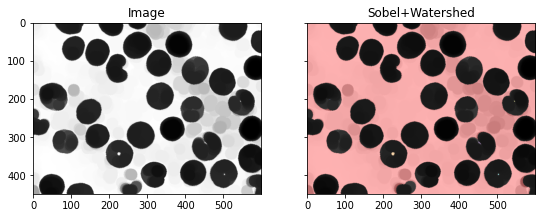

In [ ]:
# Show the segmentations.
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(9, 5),sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(r_im[0], cmap='gray')
ax[0].set_title('Image')

color1 = label2rgb(seg1, image=r_im[0], bg_label=0)
ax[1].imshow(color1)
ax[1].set_title('Sobel+Watershed')

## 4. Segmentación básica usando umbralización

Utilice el método de umbralización automática multi-Otsu (puede explorar otro) sobre alguna componente de color (verde) o sobre la versión en escala de grises de la imagen. El resultado de esto debe producir las regiones correspondientes a los hematíes. Una vez obtenida esta primera aproximación, evalué los resultados comparandolos con el ground truth. 

Para el multiotsu aplicamos el método buscando únicamente dos clases. El resultado nos separá las hematíes del resto de elementos.

In [ ]:
# Segmentación utilizando el multiotsu
thresholds = [threshold_multiotsu(I,classes=2) for I in r_im]
regions = [np.digitize(r_im[i], bins=thresholds[i]) for i in range(55)]

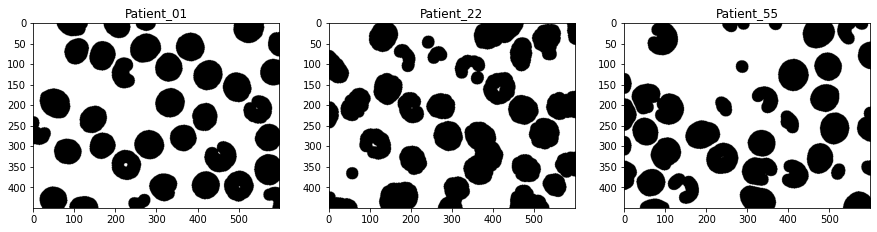

In [ ]:
# Regiones del multi-otsu
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

ax[0].imshow(regions[0],cmap='gray');
ax[1].imshow(regions[22],cmap='gray');
ax[2].imshow(regions[54],cmap='gray');

ax[0].set_title('Patient_01');
ax[1].set_title('Patient_22');
ax[2].set_title('Patient_55');

Luego obtenemos la region de los hematíes que nos interesa del Multi-Otsu y lo comparamos con al escala de azules de la imagen de segmentacion original (ground_trouth)

In [ ]:
# Obteniendo region de las hematies (region 0)
otsu = [r==0 for r in regions]

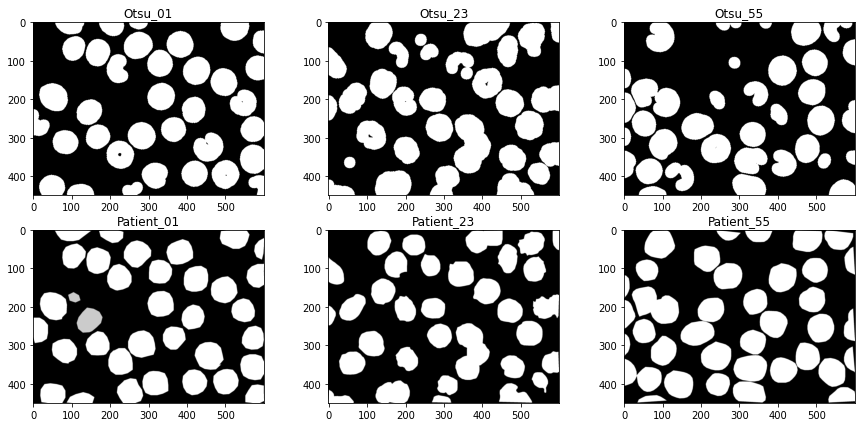

In [ ]:
# Graficando metodo de umbralizacion
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))

ax[0,0].imshow(otsu[0],cmap='gray');
ax[0,0].set_title('Otsu_01');
ax[0,1].imshow(otsu[22],cmap='gray');
ax[0,1].set_title('Otsu_23');
ax[0,2].imshow(otsu[54],cmap='gray');
ax[0,2].set_title('Otsu_55');

ax[1,0].imshow(r_gt[0],cmap='gray');
ax[1,0].set_title('Patient_01');
ax[1,1].imshow(r_gt[22],cmap='gray');
ax[1,1].set_title('Patient_23');
ax[1,2].imshow(r_gt[54],cmap='gray');
ax[1,2].set_title('Patient_55');

In [ ]:
# Calculando media de la metrica de segmentacion
Iouf_1_mean = np.mean([Iouf(r_gt[i],otsu[i]) for i in range(55)])
registro = {'Metodo':'umbralización','Valor':Iouf_1_mean}
df = df.append(registro,ignore_index=True)

## 5. Segmentación básica usando detección de bordes.

Realice la segmentación de los hematíes usando una técnica de detección de bordes usando el método de Canny (recuerde que diferentes sigmas arrojan diferentes resultados). Combine la detección con algunas técnicas de morfología matemática para generar las regiones de interés (dilatación, engrosamiento, llenado de huecos, etc).

Primero aplicamos una dilatación sobre las imagenes para separar lo más que se pueda las hematíes.

In [ ]:
# Aplicando dilatacion para separar las hematies
I_erosion = [morphology.dilation(I, morphology.disk(10)) for I in r_im]

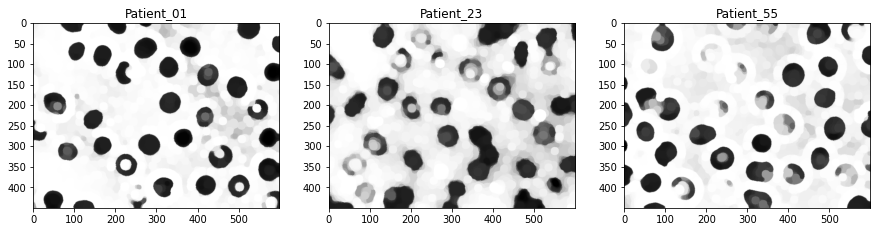

In [ ]:
# Hematies separadas
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

ax[0].imshow(I_erosion[0],cmap='gray');
ax[1].imshow(I_erosion[22],cmap='gray');
ax[2].imshow(I_erosion[54],cmap='gray');

ax[0].set_title('Patient_01');
ax[1].set_title('Patient_23');
ax[2].set_title('Patient_55');

Con el fin de mejorar los resultados, para encontrar los bordes con canny, nos lmitaremos a buscar sobre una máscara definida por aquellos píxeles cuya intensidad sea mayor al 0.75.

In [ ]:
# Encontrando los bordes con canny
Icanny = [feature.canny(I_e<0.75,0) for I_e in I_erosion]

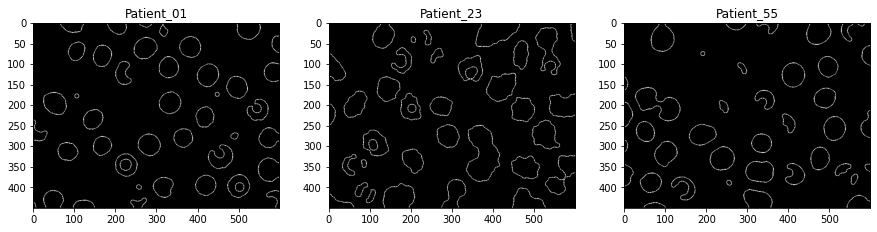

In [ ]:
# Bordes encontrados con canny
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

ax[0].imshow(Icanny[0],cmap='gray');
ax[1].imshow(Icanny[22],cmap='gray');
ax[2].imshow(Icanny[54],cmap='gray');

ax[0].set_title('Patient_01');
ax[1].set_title('Patient_23');
ax[2].set_title('Patient_55');

Ahora lo que se quiere es llenar los "huecos" de las imagnes que corresponderían a las hematíes. Para esto primero se aplicará una dilatación sobre los bordes encontrados con canny. De esta forma se cierran los "huecos".

In [ ]:
# Aplicando dilatacion para que los bordes sean mas gruesos
disco = morphology.disk(8)
Icanny = [morphology.dilation(Ic, disco) for Ic in Icanny]

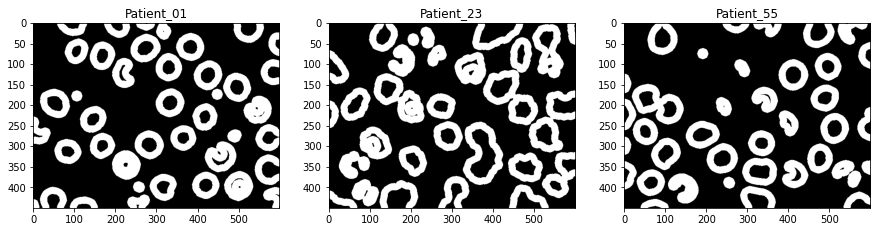

In [ ]:
# Bordes de canny mas gruesos
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

ax[0].imshow(Icanny[0],cmap='gray');
ax[1].imshow(Icanny[22],cmap='gray');
ax[2].imshow(Icanny[54],cmap='gray');

ax[0].set_title('Patient_01');
ax[1].set_title('Patient_23');
ax[2].set_title('Patient_55');

In [ ]:
# Llenando las hematies encontradas
mascara = [ndimage.binary_fill_holes(Ic) for Ic in Icanny]

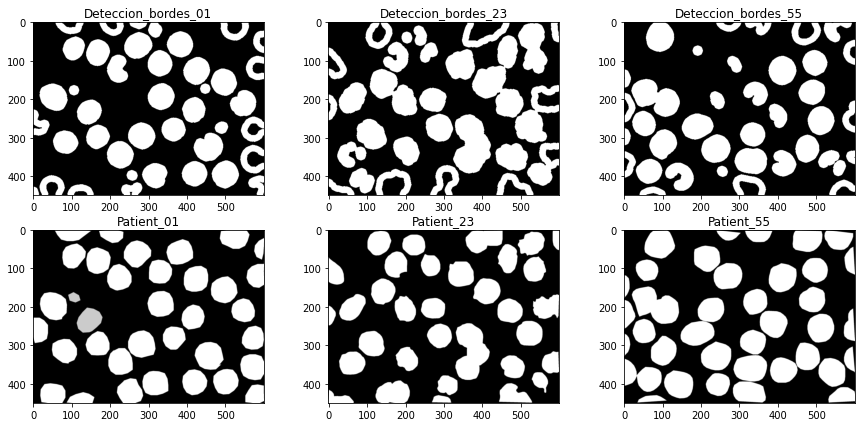

In [ ]:
# Graficando detección de bordes
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))

ax[0,0].imshow(mascara[0],cmap='gray');
ax[0,0].set_title('Deteccion_bordes_01');
ax[0,1].imshow(mascara[22],cmap='gray');
ax[0,1].set_title('Deteccion_bordes_23');
ax[0,2].imshow(mascara[54],cmap='gray');
ax[0,2].set_title('Deteccion_bordes_55');

ax[1,0].imshow(r_gt[0],cmap='gray');
ax[1,0].set_title('Patient_01');
ax[1,1].imshow(r_gt[22],cmap='gray');
ax[1,1].set_title('Patient_23');
ax[1,2].imshow(r_gt[54],cmap='gray');
ax[1,2].set_title('Patient_55');

Esto fue lo maximo que pudimos llegar de reconocimiento, ya que el canny no es capaz de detectar bordes que se sobreponen o que no se encuentre cerrados. Esto noes no detecta los hematies a a la mitad correspondientes al borde o los sobrepuestos.

In [ ]:
# Calculando media de la metrica de segmentacion
Iouf_2_mean = np.mean([Iouf(r_gt[i],mascara[i]) for i in range(10)])
registro = {'Metodo':'Detección de Bordes','Valor':Iouf_2_mean}
df = df.append(registro,ignore_index=True)

## 6. Segmentación usando clustering/ superpixels 

En este punto debe crear una segmentación similar a la del taller anterior. Es decir, usando k-means clustering para segmentar los hematíes y la combinación de la técnica SLIC (O Watershed) para generar superpixels y posteriormente el uso del clustering para segmentar.  Si usa Gaussian Mixture Models (`sklearn.mixture.GaussianMixture`) como técnica de clustering probando diferentes tipos de covarianza, recibirá bonificación en la calificación. 

Consejo: No trabaje  únicamente en el espacio de Color RGB, otros espacios pueden ser más efectivos como el Lab o YCBCr  

In [ ]:
# Obteniendo super-pixel
labels = [slic(I,n_segments=200) for I in r_im]
g = [mark_boundaries(r_im[i], labels[i]) for i in range(55)]

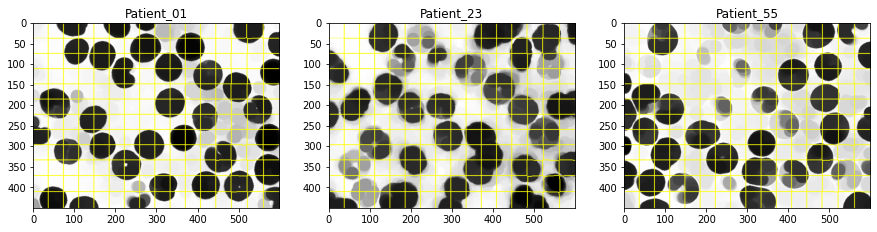

In [ ]:
# Super-pixels obtenidos
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

ax[0].imshow(g[0],cmap='gray');
ax[1].imshow(g[22],cmap='gray');
ax[2].imshow(g[54],cmap='gray');

ax[0].set_title('Patient_01');
ax[1].set_title('Patient_23');
ax[2].set_title('Patient_55');

In [ ]:
# Definiendo Modelo GMM
gm = GaussianMixture(n_components=3, random_state=0)

# Entrenando modelos
gm_train = [gm.fit(I.reshape(-1,3)) for I in g]

# Predicciones del modelo
P = [gm.predict(I.reshape(-1,3)) for I in g]

In [ ]:
# Acomodando dimensiones de la matriz y seleccionando la etiqueta 0
A = [I.reshape(g[0].shape[0:2])==0 for I in P]

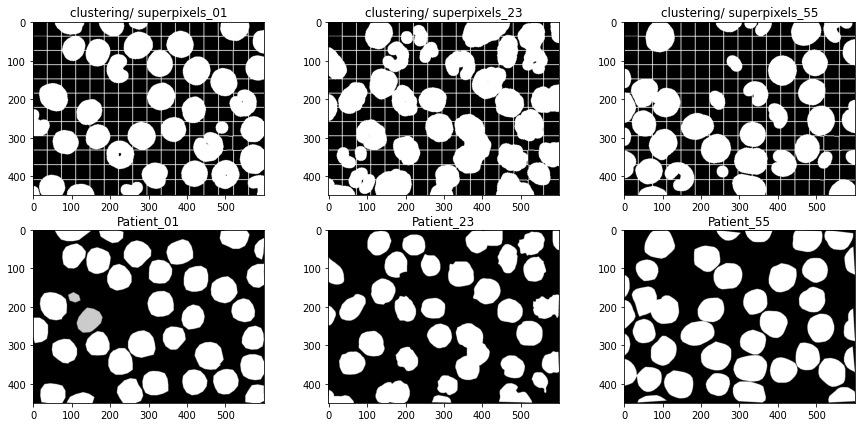

In [ ]:
# Obteniendo componentes etiquetados como 0
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))

ax[0,0].imshow((A[0]+1)%2,cmap='gray');
ax[0,0].set_title('clustering/ superpixels_01');
ax[0,1].imshow((A[22]+1)%2,cmap='gray');
ax[0,1].set_title('clustering/ superpixels_23');
ax[0,2].imshow((A[54]+1)%2,cmap='gray');
ax[0,2].set_title('clustering/ superpixels_55');

ax[1,0].imshow(r_gt[0],cmap='gray');
ax[1,0].set_title('Patient_01');
ax[1,1].imshow(r_gt[22],cmap='gray');
ax[1,1].set_title('Patient_23');
ax[1,2].imshow(r_gt[54],cmap='gray');
ax[1,2].set_title('Patient_55');

Con tres componentes predice muy bien ! 

In [ ]:
# Calculando media de la metrica de segmentacion
Iouf_3_mean = np.mean([Iouf(r_gt[i],(A[i]+1)%2) for i in range(55)])
registro = {'Metodo':'Clustering/Super Pixel','Valor':Iouf_3_mean}
df = df.append(registro,ignore_index=True)

## 7. Segmentación usando transformación Watershed y marcadores internos y externos

- Determine el gradiente de la imagen (sobre el verde o en escala de grises)
- Determine los marcadores externos e internos usara para la transformación Watershed (parámetro markers de segmentation.watershed):
    - Como marcador interno puede usar las regiones binarias del punto (4) adelgazando su tamaño. 
    - Para determinar el marcador externo , puede encontrar las líneas watershed de la transformada distancia (`distancia = ndi.distance_transform_edt(image)`) del marcador interno. Es decir, aplicando `watershed(distancia)` y determinando sólo los bordes de las regiones de la transformación watershed. 
    - Una el marcador interno y el marcador externo, este serán los `markers`. 
- Aplique la transformación Watershed sobre la imagen (en grises) con los marcadores encontrados anteriormente.

Algunas referencias útiles para este punto son:
- https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_marked_watershed.html

- https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html#sphx-glr-auto-examples-segmentation-plot-watershed-py

- https://la.mathworks.com/help/images/marker-controlled-watershed-segmentation.html

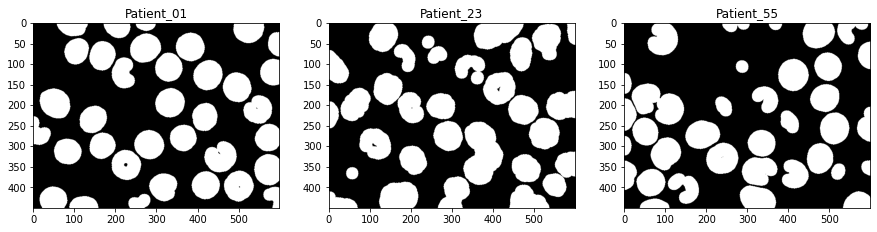

In [ ]:
# Imagen binaria (del punto 4) para marcadores internos
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

ax[0].imshow(otsu[0],cmap='gray');
ax[1].imshow(otsu[22],cmap='gray');
ax[2].imshow(otsu[54],cmap='gray');

ax[0].set_title('Patient_01');
ax[1].set_title('Patient_23');
ax[2].set_title('Patient_55');

In [ ]:
# Quitando huecos
otsu_f = [ndimage.binary_fill_holes(I) for I in otsu]

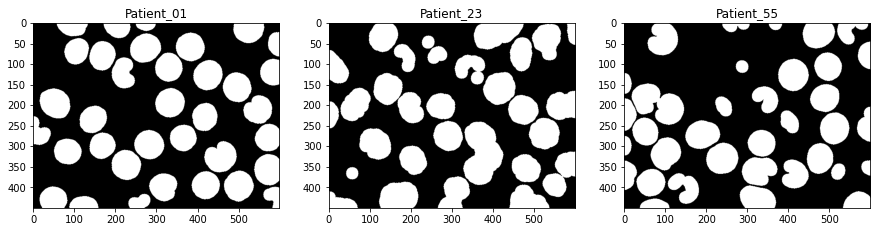

In [ ]:
# Graficando resultados sin huecos
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

ax[0].imshow(otsu_f[0],cmap='gray');
ax[1].imshow(otsu_f[22],cmap='gray');
ax[2].imshow(otsu_f[54],cmap='gray');

ax[0].set_title('Patient_01');
ax[1].set_title('Patient_23');
ax[2].set_title('Patient_55');

### Marcadores Internos

Es necesario aplicar una erosion para adelgazar los puntos.

In [ ]:
# Marcadores internos, adelgazando puntos
inside_markers = [morphology.erosion(I,morphology.disk(27)) for I in otsu_f]

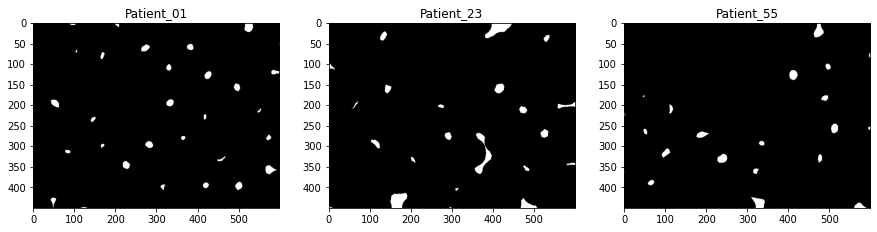

In [ ]:
# Graficando marcadores internos
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

ax[0].imshow(inside_markers[0],cmap='gray');
ax[1].imshow(inside_markers[22],cmap='gray');
ax[2].imshow(inside_markers[54],cmap='gray');

ax[0].set_title('Patient_01');
ax[1].set_title('Patient_23');
ax[2].set_title('Patient_55');

### Marcadores Externos

In [ ]:
# Marcadores externos, calculando transformada de distancia
distancia = [scipy.ndimage.morphology.distance_transform_edt(~I) for I in inside_markers]

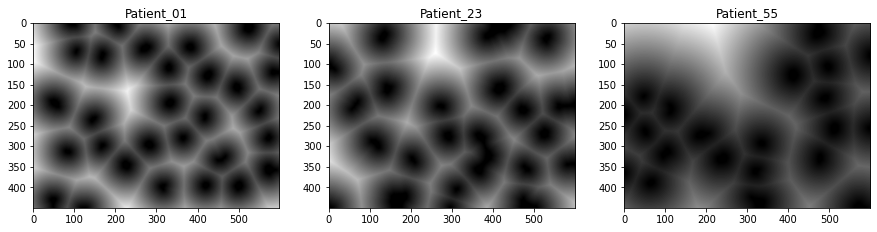

In [ ]:
# Graficando transformaciones distancia
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

ax[0].imshow(distancia[0],cmap='gray');
ax[1].imshow(distancia[22],cmap='gray');
ax[2].imshow(distancia[54],cmap='gray');

ax[0].set_title('Patient_01');
ax[1].set_title('Patient_23');
ax[2].set_title('Patient_55');

In [ ]:
# Calculando los marcadores externos
outside_markers = [watershed(d,watershed_line=True)==0 for d in distancia]

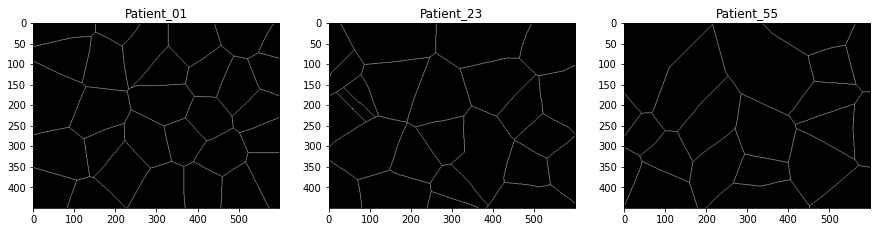

In [ ]:
# Graficando marcadores externos
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

ax[0].imshow(outside_markers[0],cmap='gray');
ax[1].imshow(outside_markers[22],cmap='gray');
ax[2].imshow(outside_markers[54],cmap='gray');

ax[0].set_title('Patient_01');
ax[1].set_title('Patient_23');
ax[2].set_title('Patient_55');

### Marcadores

In [ ]:
# Uniendo marcadores
markers = [np.logical_or(im,om) for im,om in zip(inside_markers,outside_markers)]

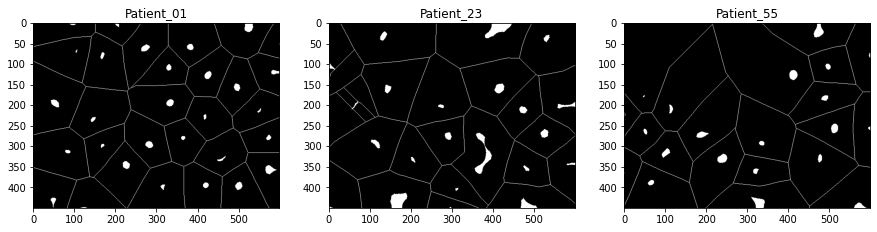

In [ ]:
# Graficando marcadores
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

ax[0].imshow(markers[0],cmap='gray');
ax[1].imshow(markers[22],cmap='gray');
ax[2].imshow(markers[54],cmap='gray');

ax[0].set_title('Patient_01');
ax[1].set_title('Patient_23');
ax[2].set_title('Patient_55');

In [ ]:
# Segmentando imagen
watershed_segm = [watershed(I,M,mask=m) for I,M,m in zip(r_im,markers,otsu_f)]

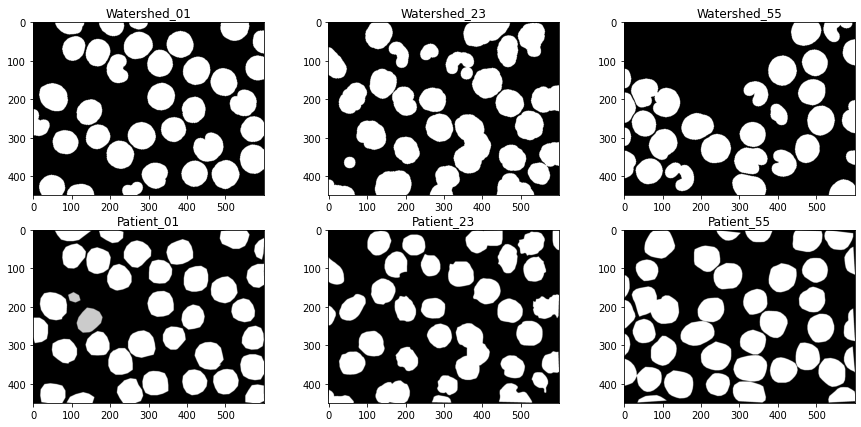

In [ ]:
# Graficando circulos
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))

ax[0,0].imshow(watershed_segm[0],cmap='gray');
ax[0,0].set_title('Watershed_01');
ax[0,1].imshow(watershed_segm[22],cmap='gray');
ax[0,1].set_title('Watershed_23');
ax[0,2].imshow(watershed_segm[54],cmap='gray');
ax[0,2].set_title('Watershed_55');

ax[1,0].imshow(r_gt[0],cmap='gray');
ax[1,0].set_title('Patient_01');
ax[1,1].imshow(r_gt[22],cmap='gray');
ax[1,1].set_title('Patient_23');
ax[1,2].imshow(r_gt[54],cmap='gray');
ax[1,2].set_title('Patient_55');

In [ ]:
# Calculando media de la metrica de segmentacion
Iouf_4_mean = np.mean([Iouf(r_gt[i],watershed_segm[i]) for i in range(55)])
registro = {'Metodo':'Watershed','Valor':Iouf_4_mean}
df = df.append(registro,ignore_index=True)

## 8. Inferencia sobre las regiones traslapadas de los hematíes.

La transformada de Hough en su forma más simple es un método para detectar líneas rectas, pero también se puede usar para detectar círculos o elipses. El algoritmo asume que se detecta el borde y es robusto contra el ruido o los puntos faltantes.

Algunos hematíes se traslapan, esto se puede ver en la figura al comienzo, o en la figura que muestra las regiones etiquetas usando cvat (final del primer punto). Dado que las regiones de los hematíes son aproximadamente circulares o elípticas usaremos la transformada de Hough Circular y Elíptica para inferir las regiones de los hematíes, incluso algunas de las que se traslapan. 

Para realizar este procedimiento debe primero genear los bordes (por ejemplo con Canny) y luego proceder con la transformada de Hough Cicular o  Elíptica (`skimage.transform.hough_circle`, `skimage.transform.hough_ellipse`) para realizar la transformación al espacio de parámetros y acumular los posibles círculos y elipses. Con las mejores posibilidades de circulos o elipses puede trazar las regiones y generar las máscaras. 

[Este tutorial](https://scikit-image.org/docs/dev/auto_examples/edges/plot_circular_elliptical_hough_transform.html) le será muy útil para este punto. 

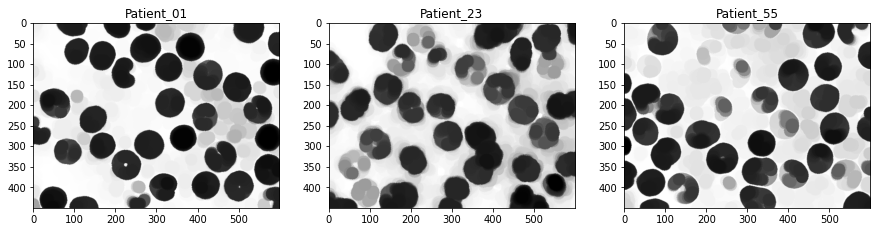

In [ ]:
# Imagenes en blanco y ne
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

ax[0].imshow(r_im[0],cmap='gray');
ax[1].imshow(r_im[22],cmap='gray');
ax[2].imshow(r_im[54],cmap='gray');

ax[0].set_title('Patient_01');
ax[1].set_title('Patient_23');
ax[2].set_title('Patient_55');

In [ ]:
# Buscando bordes con canny
edges = [canny(I<0.76,sigma=0) for I in r_im]

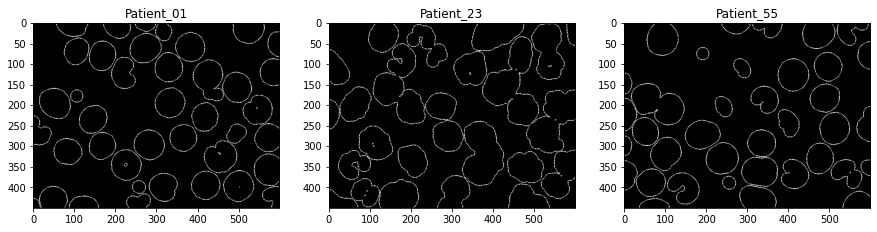

In [ ]:
# Graficando bordes de canny
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

ax[0].imshow(edges[0],cmap='gray');
ax[1].imshow(edges[22],cmap='gray');
ax[2].imshow(edges[54],cmap='gray');

ax[0].set_title('Patient_01');
ax[1].set_title('Patient_23');
ax[2].set_title('Patient_55');

## Método de hough con circulos

In [ ]:
# Aplicando el algoritmo de hough para circulos
hough_radii = np.arange(25, 40, 5)
hough_res = [skimage.transform.hough_circle(e,hough_radii) for e in edges]

In [ ]:
# Encontrando mejores circulos
circles = [transform.hough_circle_peaks(hr, hough_radii,num_peaks=100) for hr in hough_res]

In [ ]:
# Calculando los circulos encontrados
w,h = r_im[0].shape
zeros = np.zeros((w,h,55))
for i,circle in enumerate(circles):
    accums, cx, cy, radii = circle
    for center_y,center_x,radius in zip(cy,cx,radii):
        circy, circx = skimage.draw.circle(center_y, center_x, radius,shape=r_im[i].shape)
        zeros[circy, circx,i] = 1

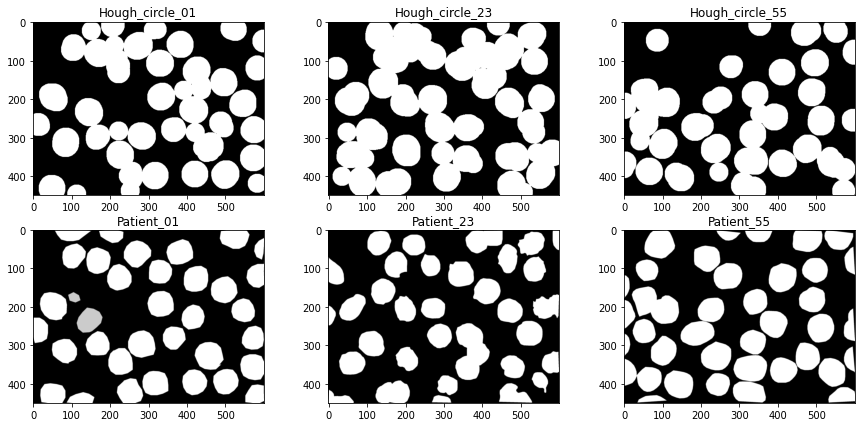

In [ ]:
# Graficando circulos
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))

ax[0,0].imshow(zeros[:,:,0],cmap='gray');
ax[0,0].set_title('Hough_circle_01');
ax[0,1].imshow(zeros[:,:,22],cmap='gray');
ax[0,1].set_title('Hough_circle_23');
ax[0,2].imshow(zeros[:,:,54],cmap='gray');
ax[0,2].set_title('Hough_circle_55');

ax[1,0].imshow(r_gt[0],cmap='gray');
ax[1,0].set_title('Patient_01');
ax[1,1].imshow(r_gt[22],cmap='gray');
ax[1,1].set_title('Patient_23');
ax[1,2].imshow(r_gt[54],cmap='gray');
ax[1,2].set_title('Patient_55');

In [ ]:
# Calculando media de la metrica de segmentacion
Iouf_5_mean = np.mean([Iouf(r_gt[i],zeros[:,:,i]) for i in range(55)])
registro = {'Metodo':'Hough-Circulos','Valor':Iouf_5_mean}
df = df.append(registro,ignore_index=True)

## 9.  Método de segmentación propio o combinado. 
En este punto cree un procedimiento para segmentar los hematíes usando una combinación de los métodos anteriores o, aplicando un método que no se haya usado como Graph cuts, contornos activos, etc.

In [ ]:
# Aplicando método de felzenszwalb
segments_fz = [felzenszwalb(of, scale=100, sigma=0.5, min_size=50) for of in otsu_f]

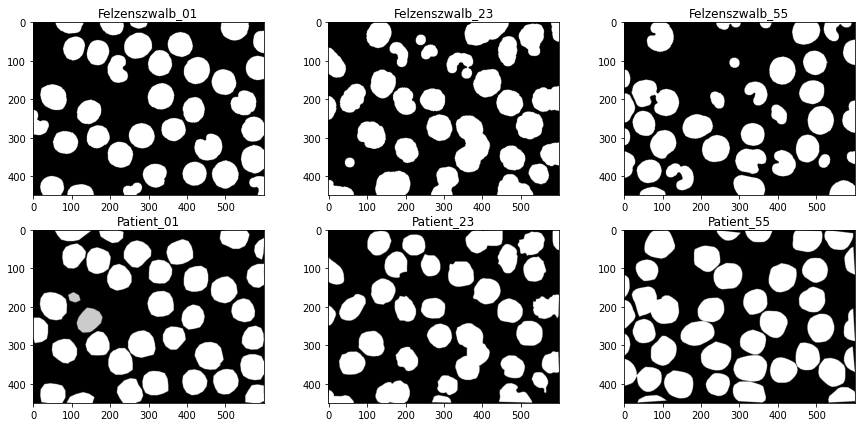

In [ ]:
# Graficando resultado del felzenszwalb
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))

ax[0,0].imshow(mark_boundaries(otsu_f[0],segments_fz[0])[:,:,2],cmap='gray');
ax[0,0].set_title('Felzenszwalb_01');
ax[0,1].imshow(mark_boundaries(otsu_f[22],segments_fz[22])[:,:,2],cmap='gray');
ax[0,1].set_title('Felzenszwalb_23');
ax[0,2].imshow(mark_boundaries(otsu_f[54],segments_fz[54])[:,:,2],cmap='gray');
ax[0,2].set_title('Felzenszwalb_55');

ax[1,0].imshow(r_gt[0],cmap='gray');
ax[1,0].set_title('Patient_01');
ax[1,1].imshow(r_gt[22],cmap='gray');
ax[1,1].set_title('Patient_23');
ax[1,2].imshow(r_gt[54],cmap='gray');
ax[1,2].set_title('Patient_55');

In [ ]:
# Calculando media de la metrica de segmentacion
Iouf_6_mean = np.mean([Iouf(r_gt[i],mark_boundaries(otsu_f[i], segments_fz[i])[:,:,2]) for i in range(55)])
registro = {'Metodo':'Felzenszwalb','Valor':Iouf_6_mean}
df = df.append(registro,ignore_index=True)

## 10. Comparación de los resultados

Recuerde que para cada segmentación debe evaluar el método en todo el ground truth usando el índice de Jaccard (o IoU). Es este punto cree una tabla comparando el valor promedio del índice sobre todas las imágenes para cada método. ¿Cuál fue el mejor método?  ¿Por qué funciono mejor? ¿Por qué los otros métodos no son tan buenos?

### Tabla de valores

In [ ]:
df

,Metodo,Valor
0,umbralización,0.777417
1,Detección de Bordes,0.763064
2,Clustering/Super Pixel,0.730118
3,Watershed,0.757354
4,Hough-Circulos,0.699125
5,Felzenszwalb,0.728811


## Entregables

Para este proyecto debera entregar el desarrollo y visualización de los resultados en un notebook de jupyter donde se muestre el código realizado (y las pruebas). También, debe entregar un pequeño informe (máximo 4 páginas) del proyecto con una breve descripción del mismo explicando el enfoque desarrollado y el análisis de los resultados .(Puede ser otro notebook, pero sin código, o un documento en PDF).

Es aconsejable en el notebook solo mostrar las imágenes (resultados) en un formato comprimido (jpg por ejm).  Muestre los resultados mostrando las imagenes originales y las posteriores al procedimiento. 
Describa cualquier idea extra implementada. 

Nota: Si les tarda mucho tiempo de ejecución al proceder con las imágenes originales, reduzca su tamaño por ejemplo a la mitad. 